### **1. Définir la structure de la stratégie**

#### **Hypothèse principale :**
Le modèle GRU génère des prévisions suffisamment précises pour détecter les tendances à court terme ou les retournements.

#### **Signal de trading :**
- Utiliser la prévision du cours à 1 minute pour déterminer si le prix augmentera ou diminuera par rapport au prix actuel.
- Si la prévision indique une hausse (supérieure au prix actuel + seuil), acheter.
- Si la prévision indique une baisse (inférieure au prix actuel - seuil), ne rien faire.

#### **Objectif :**
Capturer les micro-mouvements de prix avec un strict contrôle du risque.

---

### **2. Définir l'environnement de recherche**

- **Language de programmation utilisé** : Python3

- **Librairie utilisées** : 
  - `pandas` & `numpy`: Gestion des données
  - `binance.client` : Improtation des données et passage des ordres
  - `torch` : Entraînement du modèle GRU
  - `sklearn` : Préprocessing des données
  - `matplotlib.pyplot` & `seaborn` : Visualisation des données

---

### **4. Description univariée et bivariée du jeu de données**

In [1]:
from datetime import datetime
import os
import pandas as pd

ticker = 'BTCUSDT'
interval = '1m'
start_date = (2024, 6, 15, 0, 0, 0)
end_date = (2025, 1, 15, 0, 0, 0)

start_date_str = datetime(*start_date).strftime('%Y%m%d')
end_date_str = datetime(*end_date).strftime('%Y%m%d')
dataset_path = os.getcwd()+f'\\dataset\\{ticker}-{interval}-{start_date_str}-{end_date_str}.csv'

dataset = pd.read_csv(dataset_path, index_col='Open Time')

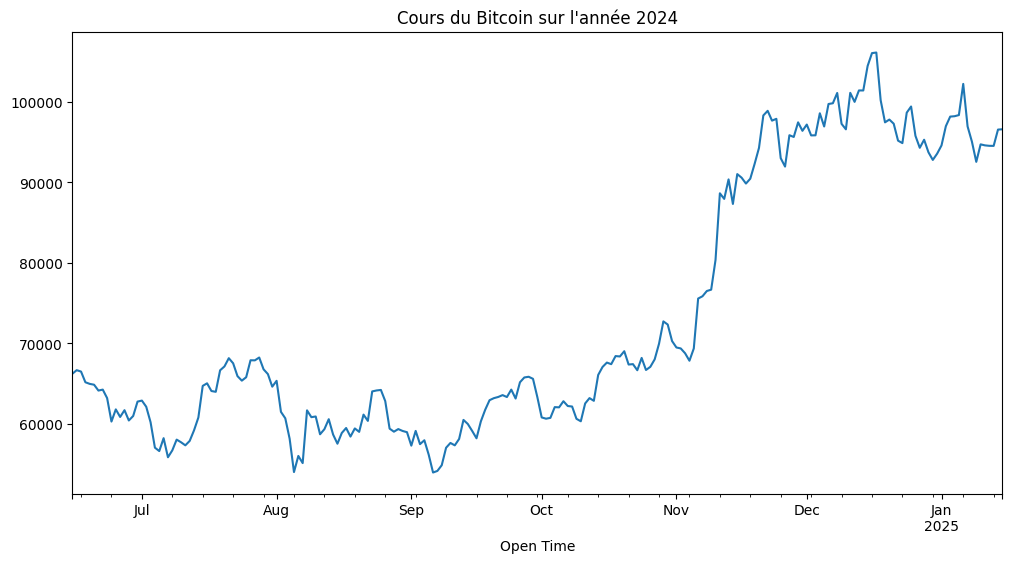

In [2]:
import matplotlib.pyplot as plt
df = dataset.copy()
df.index = pd.to_datetime(dataset.index)
df['Close'].resample('D').last().plot(figsize=(12,6), title="Cours du Bitcoin sur l'année 2024")
plt.show()

### **2. Déterminer les seuils de décision**

#### **2.1. Éviter le bruit du marché :**
- Calculer un seuil minimal de variation basé sur la volatilité moyenne du BTC (par exemple, l'ATR sur une fenêtre de 14 minutes).
  $$
  \text{Seuil d'achat} = \text{Close}_t + k \cdot \text{ATR}
  $$

---

#### **2.2. Calcul de l'ATR :**

##### **2.3.1. Calculer la True Range (TR)** :
   $$
   \text{TR} = \max\left\{\text{High} - \text{Low}, \left|\text{High} - \text{Close}_{\text{t}}\right|, \left|\text{Low} - \text{Close}_{\text{t-1}}\right|\right\}
   $$

##### **2.3.2. Calculer l'ATR** :
   L'ATR est une moyenne mobile exponentielle ou simple des TR sur une période définie (par défaut, 14 périodes).
   $$
   \text{ATR} = \frac{\sum_{i=1}^{n} \text{TR}_i}{n}
   $$

---

#### **2.3. Calcul du k**

##### **2.2.1. Basé sur la volatilité moyenne**
- Utiliser une règle empirique qui ajuste \( k \) en fonction de la volatilité historique :
  $$
  k = \frac{\text{Volatilité historique moyenne (sur une période longue)}}{\text{ATR actuel (période courte)}}
  $$
- Cette méthode adapte \( k \) à des régimes de volatilité différents, rendant la stratégie plus dynamique.

##### **2.2.2. Par optimisation statistique**
- Maximiser une métrique cible via une méthode d’optimisation :
  - **Fonction objectif** : Maximiser un indicateur comme le ratio de Sharpe ou minimiser le drawdown.
  - **Techniques** : Utiliser des algorithmes d’optimisation comme la descente de gradient, les algorithmes génétiques ou la recherche bayésienne.

##### **2.2.3. Basé sur des ratios de gestion de risque**
- Choisir \( k \) pour que la distance seuil soit proportionnelle à un risque cible.
  $$
  k = \frac{\text{Risque cible par trade}}{\text{Valeur moyenne de l'ATR}}
  $$
  - Par exemple, si le risque cible est de 1% du capital total et l'ATR moyen est de 50 (en termes de variation de prix), \( k \) peut être ajusté pour que le seuil corresponde à une distance alignée avec ce risque.

In [3]:
import pandas as pd

def actual_true_range(high: pd.Series, low: pd.Series, close: pd.Series) -> float:
    """
    Calculer l'Average True Range (ATR) à partir de séries temporelles et retourner la dernière valeur.

    Paramètres :
        high (pd.Series) : Série temporelle des prix les plus hauts.
        low (pd.Series) : Série temporelle des prix les plus bas.
        close (pd.Series) : Série temporelle des prix de clôture.
        window (int) : La période de calcul pour l'ATR (par défaut : 14).

    Retourne :
        float : La dernière valeur de l'ATR calculée.
    """
    # Vérifier que les séries ont la même longueur
    if len(high) != len(low) or len(high) != len(close):
        raise ValueError("Les séries 'high', 'low' et 'close' doivent avoir la même longueur.")

    tr1 = high - low
    tr2 = (high - close.shift(1)).abs()
    tr3 = (low - close.shift(1)).abs()
    true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    return sum(true_range) / len(close)

actual_true_range(high=dataset.High, low=dataset.Low, close=dataset.Close)

53.159682698321774

In [4]:
import numpy as np
import pandas as pd

def average_volatility(history: pd.Series, timeperiod: int = 255, freq: str = 'D') -> float:
    """
    #### Description:
    Calculate the average volatility of a financial instrument over a specified time period.

    #### Parameters:
    - history (pd.Series): Time series data representing the historical prices or returns of the financial instrument.
    - timeperiod (int, optional): The number of periods to consider for calculating the average volatility. Default is 255.
    - freq (str, optional): The frequency to which the historical data should be resampled.

    #### Returns:
    - float: Average volatility over the specified time period.
    """
    history.index = pd.to_datetime(history.index)
    history = history.resample(freq).last()
    returns = history.pct_change(fill_method=None).dropna()
    return np.std(returns) * np.sqrt(timeperiod)

In [6]:
from tqdm import tqdm
volatility_window = 60*24*30
atr_window = 60

for n in tqdm(range(max(volatility_window, atr_window), len(dataset))):
    price = dataset.Close.iloc[n]
    atr = actual_true_range(
        high=dataset.High.iloc[n-atr_window:n],
        low=dataset.Low.iloc[n-atr_window:n],
        close=dataset.Close.iloc[n-atr_window:n]
    )
    v = average_volatility(history=dataset.Close.iloc[n-volatility_window:n])
    dataset.at[dataset.index[n], 'Threshold'] = price + v * atr

  0%|          | 1222/264961 [00:14<51:25, 85.48it/s]C:\Users\Matteo\AppData\Local\Temp\ipykernel_8600\1529318926.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  history.index = pd.to_datetime(history.index)
  1%|          | 2656/264961 [00:31<55:10, 79.25it/s]  C:\Users\Matteo\AppData\Local\Temp\ipykernel_8600\1529318926.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  history.index = pd.to_datetime(history.index)
  2%|▏         | 4097/264961 [00:50<58:02, 74.91it/s]  C:\Users\Matteo\AppData\Local\Temp\ipykernel_8600\1529318926.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please spe

In [13]:
(dataset['Threshold'] - dataset.Close).describe()

count    264961.000000
mean         23.433816
std          19.031115
min           0.630654
25%          10.764371
50%          18.004046
75%          30.227562
max         274.963756
dtype: float64

---

### **3. Intégrer des règles de gestion de risque**

- **Stop-loss dynamique** : Fixer un stop-loss basé sur un pourcentage (par exemple, 0.5% du prix d'entrée) ou une volatilité récente.
- **Take-profit** : Fermer une position dès qu'un gain cible est atteint (par exemple, 1%).
- **Taille des positions** : Déterminer la taille de la position en fonction du risque maximum par trade (par exemple, 0.5% du capital total).
- **Limiter les positions simultanées** : N'avoir qu'une seule position ouverte à tout moment pour réduire les risques de sur-engagement.

---

### **4. Gérer les coûts de transaction**

Les frais et le slippage peuvent considérablement réduire la rentabilité :
- Utiliser des ordres limités pour éviter un slippage important.
- Intégrer les coûts de transaction dans le calcul du seuil de décision.

---

### **5. Ajouter des filtres supplémentaires**

#### **Contexte de marché :**
- Éviter de trader pendant des périodes de faible volume (par exemple, heures de nuit en UTC).
- Filtrer les signaux pendant des annonces macroéconomiques importantes qui peuvent provoquer une forte volatilité imprévisible.

#### **Confirmation de signal :**
- Ajouter une confirmation basée sur des indicateurs techniques (par exemple, RSI ou MACD) pour valider les signaux du modèle GRU.

---

### **6. Automatiser la stratégie**

- **Pipeline automatisé** : 
  1. Charger les données en temps réel (flux des prix du BTC).
  2. Faire une prévision avec le modèle GRU.
  3. Déterminer le signal d'achat.
  4. Exécuter l'ordre en fonction du signal.
  5. Monitorer les positions ouvertes et appliquer des règles de stop-loss/take-profit.

---

### **7. Évaluer les performances**

#### **7.1. Indicateurs suivis :**
- Ratio de Sharpe : Mesurer les rendements ajustés au risque.
- Drawdown maximal : Évaluer le risque de perte.
- Taux de réussite des trades : Proportion de trades gagnants.
- Rentabilité nette : Après coûts de transaction.

#### **7.2. Backtest et paper trading :**
- Effectuer un backtest sur les données historiques avec votre modèle GRU.
- Utiliser un environnement de paper trading pour valider la stratégie en conditions réelles sans engager de capital.

In [ ]:
# torch.load("C:\\Users\\Matteo\\Documents\\GitHub local\\PadapiGRU\\model\\0b9a708f-7f21-485b-9e74-7bb42eea10a4\\model.pth", weights_only=False)